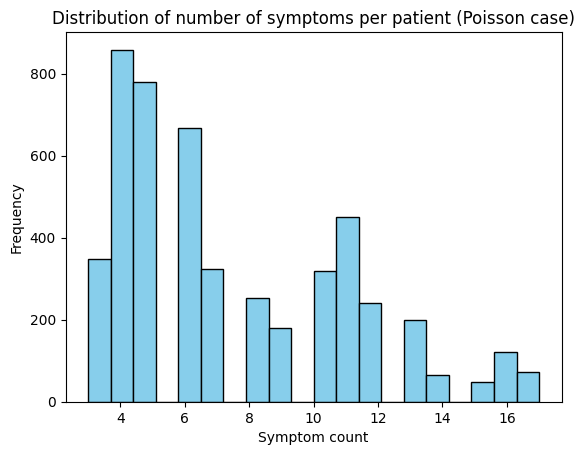

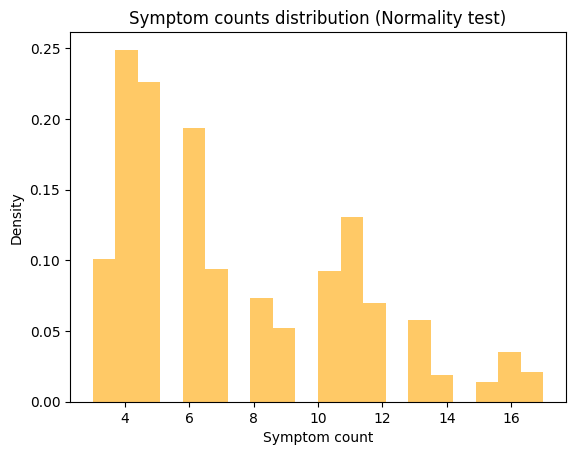

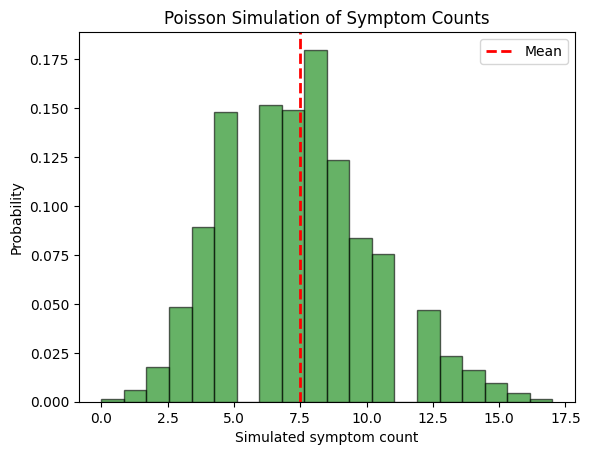


--- FINAL SUMMARY ---
Poisson → mean: 7.45 variance: 12.9
Binomial → Disease: (vertigo) Paroymsal  Positional Vertigo probability: 0.024
Normality → Shapiro p-value: 0.0
Simulation → mean: 7.48 std: 2.82
Probability of >=12 symptoms: 0.0763

Top 10 association rules:
                   antecedents                     consequents   support  \
264                   (phlegm)           (chest_pain, malaise)  0.069512   
261      (chest_pain, malaise)                        (phlegm)  0.069512   
253                   (phlegm)           (chest_pain, fatigue)  0.068293   
225       (chest_pain, chills)                        (phlegm)  0.068293   
228                   (phlegm)            (chest_pain, chills)  0.068293   
250      (chest_pain, fatigue)                        (phlegm)  0.068293   
257   (chest_pain, high_fever)                        (phlegm)  0.068293   
260                   (phlegm)        (chest_pain, high_fever)  0.068293   
361                   (phlegm)                (

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, shapiro
from mlxtend.frequent_patterns import apriori, association_rules

df = pd.read_csv("/content/dataset.csv")

symptom_cols = [c for c in df.columns if "Symptom" in c]
df[symptom_cols] = df[symptom_cols].fillna("").apply(lambda x: x.str.lower().str.replace(" ", ""))
df['all_symptoms'] = df[symptom_cols].apply(lambda row: ",".join([s for s in row if s != ""]), axis=1)

symptom_matrix = df['all_symptoms'].str.get_dummies(sep=",")
symptom_counts = symptom_matrix.sum(axis=1)

mean_sym = symptom_counts.mean()
var_sym = symptom_counts.var()

plt.hist(symptom_counts, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of number of symptoms per patient (Poisson case)")
plt.xlabel("Symptom count")
plt.ylabel("Frequency")
plt.show()

target_disease = df['Disease'].mode()[0]
successes = (df['Disease'] == target_disease).sum()
trials = len(df)
p_hat = successes / trials

stat, p = shapiro(symptom_counts)
plt.hist(symptom_counts, bins=20, density=True, alpha=0.6, color="orange")
plt.title("Symptom counts distribution (Normality test)")
plt.xlabel("Symptom count")
plt.ylabel("Density")
plt.show()

lam = mean_sym
simulated = np.random.poisson(lam=lam, size=1000)

plt.hist(simulated, bins=20, density=True, alpha=0.6, color='green', edgecolor='black')
plt.axvline(simulated.mean(), color='red', linestyle='dashed', linewidth=2, label="Mean")
plt.title("Poisson Simulation of Symptom Counts")
plt.xlabel("Simulated symptom count")
plt.ylabel("Probability")
plt.legend()
plt.show()

freq_items = apriori(symptom_matrix.astype(bool), min_support=0.05, use_colnames=True)
rules = association_rules(freq_items, metric="confidence", min_threshold=0.5)
rules = rules.sort_values("lift", ascending=False)

print("\n--- FINAL SUMMARY ---")
print("Poisson → mean:", round(mean_sym,2), "variance:", round(var_sym,2))
print("Binomial → Disease:", target_disease, "probability:", round(p_hat,3))
print("Normality → Shapiro p-value:", round(p,3))
print("Simulation → mean:", round(simulated.mean(),2), "std:", round(simulated.std(),2))
print("Probability of >=12 symptoms:", round(1 - poisson.cdf(11, lam),4))
print("\nTop 10 association rules:")
print(rules.head(10)[['antecedents','consequents','support','confidence','lift']])


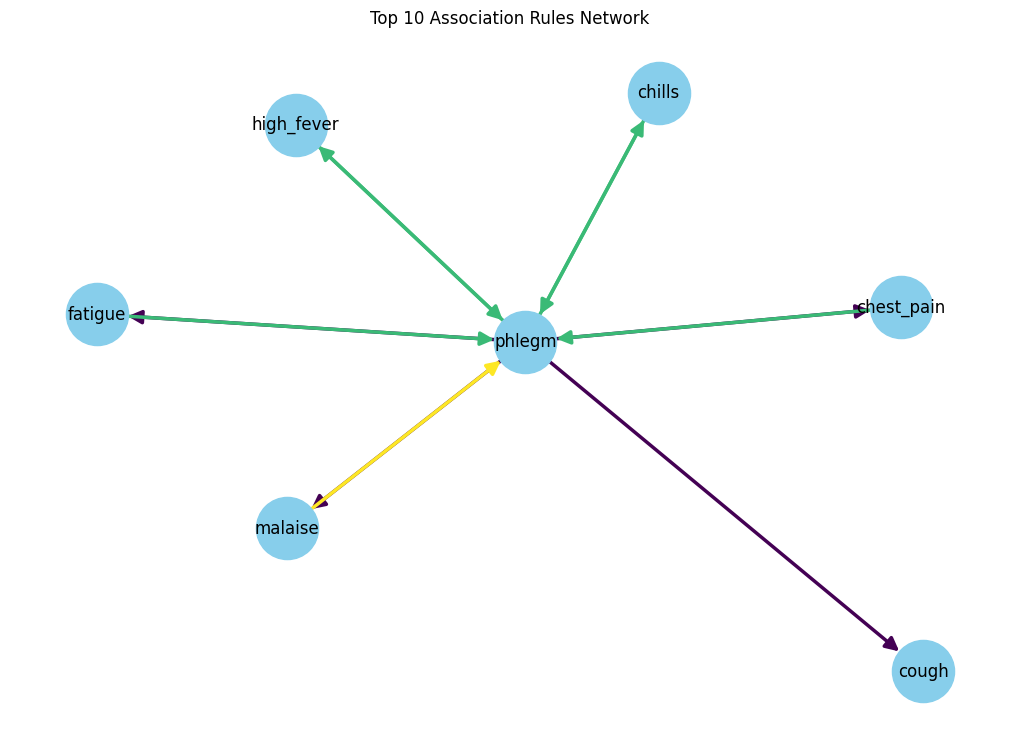

In [2]:
import networkx as nx

top_rules = rules.head(10)  # Take top 10 rules
G = nx.DiGraph()

for _, row in top_rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent, weight=row['lift'])

pos = nx.spring_layout(G, k=1, seed=42)
plt.figure(figsize=(10, 7))
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000,
        edge_color=weights, width=2.5, edge_cmap=plt.cm.viridis, arrowsize=20)
plt.title("Top 10 Association Rules Network")
plt.show()
